# Training script for combined regression approach

    1. Loading necessary data
    2. Initializing model
    3. Training loop

## 1. Loading necessary data

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import RegressionDataSet4
import torch
import numpy as np

torch.cuda.empty_cache()

annotation_dict = pickle.load(open("wsis/meningioma_grading_training_dataset/annotation_dict2.p","rb"))

In [2]:
keys_to_discard = list()
keys_for_training = list()
keys_excluded_testset=0
ldfnummer_exclude = []
testset_exclude = pickle.load(open('Testset_List.p','rb'))
for key in annotation_dict:
    if key in testset_exclude:
        ldfnummer_exclude += [annotation_dict[key]['lfd_number']]

for key in annotation_dict:
    try:
        if (annotation_dict[key]['mitotic_count'] >= 0) and (annotation_dict[key]['lfd_number'] not in ldfnummer_exclude):
            keys_for_training.append(key)
        else:
            keys_to_discard.append(key)
    except KeyError:
        keys_to_discard.append(key)
        
keys_excluded_testset,
ldfnummer_exclude = np.unique(ldfnummer_exclude)
ldfnummer_exclude
len(ldfnummer_exclude)

In [4]:
# Only the highest mitotic count of a patient is used in training
tmp = dict()
for key in annotation_dict:
    lfd_number = annotation_dict[key]['lfd_number']
    if (lfd_number in ldfnummer_exclude):
        continue
    if lfd_number not in tmp:
        tmp[lfd_number] = dict()
        tmp[lfd_number]['file'] = key
        tmp[lfd_number]['who_grade'] = annotation_dict[key]['who_grade']
        try:
            tmp[lfd_number]['mitotic_count'] = annotation_dict[key]['mitotic_count']
        except KeyError:
            tmp[lfd_number]['mitotic_count'] = 0
    try:
        if tmp[lfd_number]['mitotic_count'] < annotation_dict[key]['mitotic_count']:
            tmp[lfd_number]['file'] = key
            tmp[lfd_number]['who_grade'] = annotation_dict[key]['who_grade']
            tmp[lfd_number]['mitotic_count'] = annotation_dict[key]['mitotic_count']
    except KeyError:
        continue

patients = tmp

In [5]:
# Standardize the mitotic count
mcs = [patients[key]['mitotic_count'] for key in patients]
mean_mcs = np.mean(mcs)
std_mcs = np.std(mcs)
mcs = [(m-mean_mcs)/std_mcs for m in mcs]
# Normalize
max_mcs = max(mcs)
mcs = [m/max_mcs for m in mcs]
for key,m in zip (patients, mcs):
    patients[key]['mitotic_count'] = m

for lfd_number in patients:
    annotation_dict[patients[lfd_number]['file']]['mitotic_count'] = patients[lfd_number]['mitotic_count']

In [7]:
import random

random.seed(2)
# 15 % validation data
val_numbers = [lfd_number for lfd_number in random.sample(patients.keys(),54)]
val_keys = [patients[lfd_number]['file'] for lfd_number in val_numbers]

train_numbers = [lfd_number for lfd_number in patients if lfd_number not in val_numbers]
train_keys = [patients[lfd_number]['file'] for lfd_number in train_numbers]

(array([260.,  17.,   6.,   1.,   0.,   2.,   0.,   0.,   0.,   1.]),
 array([-0.05500172,  0.05049845,  0.15599862,  0.2614988 ,  0.36699897,
         0.47249914,  0.57799931,  0.68349948,  0.78899966,  0.89449983,
         1.        ]),
 <BarContainer object of 10 artists>)

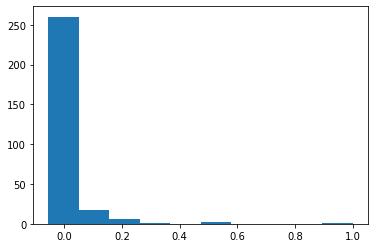

In [8]:
import matplotlib.pyplot as plt

plt.hist([annotation_dict[key]['mitotic_count'] for key in train_keys])

In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader
import random

path_to_wsis = ""

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize([0.8249, 0.5482, 0.7211], [0.0573, 0.0988, 0.0595])])


batch_size = 8

train_data = RegressionDataSet4.WhoRegressionDataSet(path_to_wsis,train_keys,annotation_dict,1000,transform,MitoticCount = True, level = 0)
train_loader = DataLoader(train_data, batch_size = batch_size, collate_fn=train_data.collate_fn)

val_data = RegressionDataSet4.WhoRegressionDataSet(path_to_wsis,val_keys,annotation_dict,100,transform,MitoticCount = True, level = 0)
val_loader = DataLoader(val_data, batch_size = batch_size, collate_fn=val_data.collate_fn)

data_loaders = {
    'train' : train_loader,
    'val' : val_loader,
}

100% (287 of 287) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
100% (54 of 54) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


## 2. Initialize model

In [11]:
import torch
from torch import optim
import Model3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model3.RegressionModel()
model = model.to(device)

# Load pretrained model3
model.fc1.load_state_dict(torch.load('models/fc1_2.pth'))
model.fc2.load_state_dict(torch.load('models/fc2_2.pth'))

# Freeze MC path
model.fc1.requires_grad = False
model.fc2.requires_grad = False

## 3. Training loop

In [10]:
from tqdm import tqdm

def train_loop(train_loader, model, loss_fn, optimizer):
    running_loss = 0
    size = train_loader.dataset.pseudo_epoch_length
    for  batch, (X,X2,y) in enumerate(train_loader):
        # Image
        X = X.to(device)
        # Mitotic Count
        X2 = X2.to(device)
        # WHO grade
        y = y.to(device)
        pred = model(X,X2)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Current batch loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    running_loss /= len(train_loader)
    print(f"Mean training loss: {running_loss:.5f}")
    return running_loss 
  
            
def test_loop(test_loader, model, loss_fn):
    size = len(test_loader)
    test_loss = 0

    with torch.no_grad():
        for X,X2,y in tqdm(test_loader):
            X = X.to(device)
            X2 = X2.to(device)
            y = y.to(device)
            pred = model(X,X2)
            test_loss += loss_fn(pred, y).item()
    test_loss /= size
    print(f"Avg loss: {test_loss:>8f} \n")
    return test_loss

In [12]:
loss_fn = torch.nn.MSELoss(reduction = 'mean')
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode = 'min', factor = 0.1, patience = 3, verbose=True)

In [13]:
epochs = 30
val_losses = list()
train_losses = list()
weight_fc4 = list()
bias_fc4 = list()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    print(f"Gewichtung des Resnetpfades: {model.fc4.weight[0][0]:.5f}, Gewichtung des MC-Pfades: {model.fc4.weight[0][1]:.5f}" )
    weight_fc4.append(model.fc4.weight.clone().detach().cpu())
    bias_fc4.append(model.fc4.bias.clone().detach().cpu())
       
    train_loss= train_loop(train_loader, model, loss_fn, optimizer)
    val_loss = test_loop(val_loader, model, loss_fn)
    
    # model selection
    if t == 0:
        best_loss = val_loss
    else:
        if val_loss < best_loss:
            best_model = model.state_dict()
            best_loss = val_loss
            
    scheduler.step(val_loss)
    val_losses.append(val_loss)
    train_losses.append(train_loss)
print("Done!")

Epoch 1
-------------------------------
Gewichtung des Resnetpfades: -0.10524, Gewichtung des MC-Pfades: 0.21723


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Current batch loss: 3.490701  [    0/ 1000]
Current batch loss: 2.221701  [   80/ 1000]
Current batch loss: 2.571667  [  160/ 1000]
Current batch loss: 1.786386  [  240/ 1000]
Current batch loss: 1.463284  [  320/ 1000]
Current batch loss: 0.830593  [  400/ 1000]
Current batch loss: 1.271371  [  480/ 1000]
Current batch loss: 0.282615  [  560/ 1000]
Current batch loss: 0.658396  [  640/ 1000]
Current batch loss: 0.547545  [  720/ 1000]
Current batch loss: 0.459657  [  800/ 1000]
Current batch loss: 0.195345  [  880/ 1000]
Current batch loss: 0.380192  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 1.03642


100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


Avg loss: 0.331826 

Epoch 2
-------------------------------
Gewichtung des Resnetpfades: -0.03784, Gewichtung des MC-Pfades: 0.64644
Current batch loss: 0.245641  [    0/ 1000]
Current batch loss: 0.396846  [   80/ 1000]
Current batch loss: 0.396319  [  160/ 1000]
Current batch loss: 0.177981  [  240/ 1000]
Current batch loss: 0.379847  [  320/ 1000]
Current batch loss: 0.251548  [  400/ 1000]
Current batch loss: 0.152396  [  480/ 1000]
Current batch loss: 0.262855  [  560/ 1000]
Current batch loss: 0.224920  [  640/ 1000]
Current batch loss: 0.293478  [  720/ 1000]
Current batch loss: 0.370276  [  800/ 1000]
Current batch loss: 0.396946  [  880/ 1000]
Current batch loss: 0.246910  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.24619


100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


Avg loss: 0.219901 

Epoch 3
-------------------------------
Gewichtung des Resnetpfades: -0.03218, Gewichtung des MC-Pfades: 0.73963
Current batch loss: 0.251590  [    0/ 1000]
Current batch loss: 0.241620  [   80/ 1000]
Current batch loss: 0.121296  [  160/ 1000]
Current batch loss: 0.127570  [  240/ 1000]
Current batch loss: 0.209241  [  320/ 1000]
Current batch loss: 0.331182  [  400/ 1000]
Current batch loss: 0.178172  [  480/ 1000]
Current batch loss: 0.280662  [  560/ 1000]
Current batch loss: 0.316522  [  640/ 1000]
Current batch loss: 0.312240  [  720/ 1000]
Current batch loss: 0.279223  [  800/ 1000]
Current batch loss: 0.363445  [  880/ 1000]
Current batch loss: 0.161479  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.22781


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Avg loss: 0.228309 

Epoch 4
-------------------------------
Gewichtung des Resnetpfades: -0.03356, Gewichtung des MC-Pfades: 0.76385
Current batch loss: 0.236063  [    0/ 1000]
Current batch loss: 0.205151  [   80/ 1000]
Current batch loss: 0.290995  [  160/ 1000]
Current batch loss: 0.117847  [  240/ 1000]
Current batch loss: 0.155481  [  320/ 1000]
Current batch loss: 0.163349  [  400/ 1000]
Current batch loss: 0.128742  [  480/ 1000]
Current batch loss: 0.403453  [  560/ 1000]
Current batch loss: 0.489162  [  640/ 1000]
Current batch loss: 0.161190  [  720/ 1000]
Current batch loss: 0.087608  [  800/ 1000]
Current batch loss: 0.238169  [  880/ 1000]
Current batch loss: 0.169679  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.21653


100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Avg loss: 0.222559 

Epoch 5
-------------------------------
Gewichtung des Resnetpfades: -0.03629, Gewichtung des MC-Pfades: 0.77210
Current batch loss: 0.256204  [    0/ 1000]
Current batch loss: 0.077615  [   80/ 1000]
Current batch loss: 0.179860  [  160/ 1000]
Current batch loss: 0.194275  [  240/ 1000]
Current batch loss: 0.165782  [  320/ 1000]
Current batch loss: 0.201072  [  400/ 1000]
Current batch loss: 0.102714  [  480/ 1000]
Current batch loss: 0.344255  [  560/ 1000]
Current batch loss: 0.162395  [  640/ 1000]
Current batch loss: 0.184784  [  720/ 1000]
Current batch loss: 0.348908  [  800/ 1000]
Current batch loss: 0.141698  [  880/ 1000]
Current batch loss: 0.364858  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.21955


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Avg loss: 0.212116 

Epoch 6
-------------------------------
Gewichtung des Resnetpfades: -0.03899, Gewichtung des MC-Pfades: 0.77888
Current batch loss: 0.169602  [    0/ 1000]
Current batch loss: 0.377374  [   80/ 1000]
Current batch loss: 0.149808  [  160/ 1000]
Current batch loss: 0.338984  [  240/ 1000]
Current batch loss: 0.166233  [  320/ 1000]
Current batch loss: 0.278007  [  400/ 1000]
Current batch loss: 0.251506  [  480/ 1000]
Current batch loss: 0.218879  [  560/ 1000]
Current batch loss: 0.198637  [  640/ 1000]
Current batch loss: 0.525938  [  720/ 1000]
Current batch loss: 0.126394  [  800/ 1000]
Current batch loss: 0.236060  [  880/ 1000]
Current batch loss: 0.162433  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.21570


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Avg loss: 0.231318 

Epoch 7
-------------------------------
Gewichtung des Resnetpfades: -0.04115, Gewichtung des MC-Pfades: 0.79030
Current batch loss: 0.230825  [    0/ 1000]
Current batch loss: 0.280759  [   80/ 1000]
Current batch loss: 0.370665  [  160/ 1000]
Current batch loss: 0.118433  [  240/ 1000]
Current batch loss: 0.332342  [  320/ 1000]
Current batch loss: 0.274237  [  400/ 1000]
Current batch loss: 0.167459  [  480/ 1000]
Current batch loss: 0.198998  [  560/ 1000]
Current batch loss: 0.284881  [  640/ 1000]
Current batch loss: 0.223552  [  720/ 1000]
Current batch loss: 0.372792  [  800/ 1000]
Current batch loss: 0.319982  [  880/ 1000]
Current batch loss: 0.169758  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.20294


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Avg loss: 0.221248 

Epoch 8
-------------------------------
Gewichtung des Resnetpfades: -0.04448, Gewichtung des MC-Pfades: 0.79467
Current batch loss: 0.229341  [    0/ 1000]
Current batch loss: 0.327725  [   80/ 1000]
Current batch loss: 0.132273  [  160/ 1000]
Current batch loss: 0.211783  [  240/ 1000]
Current batch loss: 0.238070  [  320/ 1000]
Current batch loss: 0.121551  [  400/ 1000]
Current batch loss: 0.141025  [  480/ 1000]
Current batch loss: 0.396717  [  560/ 1000]
Current batch loss: 0.060646  [  640/ 1000]
Current batch loss: 0.373005  [  720/ 1000]
Current batch loss: 0.173380  [  800/ 1000]
Current batch loss: 0.224817  [  880/ 1000]
Current batch loss: 0.122240  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.20943


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


Avg loss: 0.190284 

Epoch 9
-------------------------------
Gewichtung des Resnetpfades: -0.04719, Gewichtung des MC-Pfades: 0.80442
Current batch loss: 0.117515  [    0/ 1000]
Current batch loss: 0.190041  [   80/ 1000]
Current batch loss: 0.250255  [  160/ 1000]
Current batch loss: 0.136753  [  240/ 1000]
Current batch loss: 0.219042  [  320/ 1000]
Current batch loss: 0.233704  [  400/ 1000]
Current batch loss: 0.183193  [  480/ 1000]
Current batch loss: 0.171613  [  560/ 1000]
Current batch loss: 0.181343  [  640/ 1000]
Current batch loss: 0.095879  [  720/ 1000]
Current batch loss: 0.105114  [  800/ 1000]
Current batch loss: 0.118691  [  880/ 1000]
Current batch loss: 0.207773  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.20212


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


Avg loss: 0.224562 

Epoch 10
-------------------------------
Gewichtung des Resnetpfades: -0.05051, Gewichtung des MC-Pfades: 0.80755
Current batch loss: 0.271908  [    0/ 1000]
Current batch loss: 0.313380  [   80/ 1000]
Current batch loss: 0.349669  [  160/ 1000]
Current batch loss: 0.111146  [  240/ 1000]
Current batch loss: 0.235332  [  320/ 1000]
Current batch loss: 0.314029  [  400/ 1000]
Current batch loss: 0.329146  [  480/ 1000]
Current batch loss: 0.372563  [  560/ 1000]
Current batch loss: 0.198206  [  640/ 1000]
Current batch loss: 0.313301  [  720/ 1000]
Current batch loss: 0.232358  [  800/ 1000]
Current batch loss: 0.149649  [  880/ 1000]
Current batch loss: 0.474488  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.19726


100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Avg loss: 0.198329 

Epoch 11
-------------------------------
Gewichtung des Resnetpfades: -0.05192, Gewichtung des MC-Pfades: 0.82504
Current batch loss: 0.208854  [    0/ 1000]
Current batch loss: 0.170403  [   80/ 1000]
Current batch loss: 0.349540  [  160/ 1000]
Current batch loss: 0.109235  [  240/ 1000]
Current batch loss: 0.307483  [  320/ 1000]
Current batch loss: 0.252591  [  400/ 1000]
Current batch loss: 0.252807  [  480/ 1000]
Current batch loss: 0.134960  [  560/ 1000]
Current batch loss: 0.155285  [  640/ 1000]
Current batch loss: 0.225860  [  720/ 1000]
Current batch loss: 0.137193  [  800/ 1000]
Current batch loss: 0.209282  [  880/ 1000]
Current batch loss: 0.168026  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.20514


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Avg loss: 0.216035 

Epoch 12
-------------------------------
Gewichtung des Resnetpfades: -0.05479, Gewichtung des MC-Pfades: 0.82960
Current batch loss: 0.280088  [    0/ 1000]
Current batch loss: 0.282502  [   80/ 1000]
Current batch loss: 0.225612  [  160/ 1000]
Current batch loss: 0.207548  [  240/ 1000]
Current batch loss: 0.196286  [  320/ 1000]
Current batch loss: 0.111499  [  400/ 1000]
Current batch loss: 0.105281  [  480/ 1000]
Current batch loss: 0.305944  [  560/ 1000]
Current batch loss: 0.084063  [  640/ 1000]
Current batch loss: 0.129729  [  720/ 1000]
Current batch loss: 0.341511  [  800/ 1000]
Current batch loss: 0.347674  [  880/ 1000]
Current batch loss: 0.263611  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.21104


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


Avg loss: 0.189198 

Epoch 13
-------------------------------
Gewichtung des Resnetpfades: -0.05724, Gewichtung des MC-Pfades: 0.83933
Current batch loss: 0.065704  [    0/ 1000]
Current batch loss: 0.211831  [   80/ 1000]
Current batch loss: 0.443598  [  160/ 1000]
Current batch loss: 0.138567  [  240/ 1000]
Current batch loss: 0.152812  [  320/ 1000]
Current batch loss: 0.196017  [  400/ 1000]
Current batch loss: 0.078374  [  480/ 1000]
Current batch loss: 0.269869  [  560/ 1000]
Current batch loss: 0.238589  [  640/ 1000]
Current batch loss: 0.115304  [  720/ 1000]
Current batch loss: 0.098760  [  800/ 1000]
Current batch loss: 0.361032  [  880/ 1000]
Current batch loss: 0.291986  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.18489


100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


Avg loss: 0.204253 

Epoch 14
-------------------------------
Gewichtung des Resnetpfades: -0.06095, Gewichtung des MC-Pfades: 0.83806
Current batch loss: 0.082278  [    0/ 1000]
Current batch loss: 0.079286  [   80/ 1000]
Current batch loss: 0.350799  [  160/ 1000]
Current batch loss: 0.296022  [  240/ 1000]
Current batch loss: 0.122072  [  320/ 1000]
Current batch loss: 0.271542  [  400/ 1000]
Current batch loss: 0.102678  [  480/ 1000]
Current batch loss: 0.107913  [  560/ 1000]
Current batch loss: 0.120918  [  640/ 1000]
Current batch loss: 0.205826  [  720/ 1000]
Current batch loss: 0.271422  [  800/ 1000]
Current batch loss: 0.174757  [  880/ 1000]
Current batch loss: 0.148068  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.20180


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Avg loss: 0.198607 

Epoch 15
-------------------------------
Gewichtung des Resnetpfades: -0.06373, Gewichtung des MC-Pfades: 0.84439
Current batch loss: 0.115819  [    0/ 1000]
Current batch loss: 0.250549  [   80/ 1000]
Current batch loss: 0.086285  [  160/ 1000]
Current batch loss: 0.140207  [  240/ 1000]
Current batch loss: 0.265819  [  320/ 1000]
Current batch loss: 0.067643  [  400/ 1000]
Current batch loss: 0.188168  [  480/ 1000]
Current batch loss: 0.261055  [  560/ 1000]
Current batch loss: 0.106381  [  640/ 1000]
Current batch loss: 0.280654  [  720/ 1000]
Current batch loss: 0.309630  [  800/ 1000]
Current batch loss: 0.170589  [  880/ 1000]
Current batch loss: 0.085530  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.19817


100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


Avg loss: 0.216334 

Epoch 16
-------------------------------
Gewichtung des Resnetpfades: -0.06722, Gewichtung des MC-Pfades: 0.84943
Current batch loss: 0.153938  [    0/ 1000]
Current batch loss: 0.209819  [   80/ 1000]
Current batch loss: 0.229648  [  160/ 1000]
Current batch loss: 0.125503  [  240/ 1000]
Current batch loss: 0.337598  [  320/ 1000]
Current batch loss: 0.090570  [  400/ 1000]
Current batch loss: 0.066668  [  480/ 1000]
Current batch loss: 0.161609  [  560/ 1000]
Current batch loss: 0.206268  [  640/ 1000]
Current batch loss: 0.254192  [  720/ 1000]
Current batch loss: 0.205778  [  800/ 1000]
Current batch loss: 0.153578  [  880/ 1000]
Current batch loss: 0.053540  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.19258


100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


Avg loss: 0.201562 

Epoch    16: reducing learning rate of group 0 to 1.0000e-05.
Epoch 17
-------------------------------
Gewichtung des Resnetpfades: -0.07060, Gewichtung des MC-Pfades: 0.85343
Current batch loss: 0.289947  [    0/ 1000]
Current batch loss: 0.270980  [   80/ 1000]
Current batch loss: 0.445925  [  160/ 1000]
Current batch loss: 0.083940  [  240/ 1000]
Current batch loss: 0.184789  [  320/ 1000]
Current batch loss: 0.114446  [  400/ 1000]
Current batch loss: 0.350286  [  480/ 1000]
Current batch loss: 0.146174  [  560/ 1000]
Current batch loss: 0.310189  [  640/ 1000]
Current batch loss: 0.185921  [  720/ 1000]
Current batch loss: 0.118666  [  800/ 1000]
Current batch loss: 0.089831  [  880/ 1000]
Current batch loss: 0.112518  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.20393


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


Avg loss: 0.217083 

Epoch 18
-------------------------------
Gewichtung des Resnetpfades: -0.07082, Gewichtung des MC-Pfades: 0.85493
Current batch loss: 0.074330  [    0/ 1000]
Current batch loss: 0.038546  [   80/ 1000]
Current batch loss: 0.289653  [  160/ 1000]
Current batch loss: 0.166722  [  240/ 1000]
Current batch loss: 0.257980  [  320/ 1000]
Current batch loss: 0.285316  [  400/ 1000]
Current batch loss: 0.057545  [  480/ 1000]
Current batch loss: 0.165515  [  560/ 1000]
Current batch loss: 0.122050  [  640/ 1000]
Current batch loss: 0.081630  [  720/ 1000]
Current batch loss: 0.397703  [  800/ 1000]
Current batch loss: 0.231282  [  880/ 1000]
Current batch loss: 0.366520  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.20705


100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Avg loss: 0.222734 

Epoch 19
-------------------------------
Gewichtung des Resnetpfades: -0.07106, Gewichtung des MC-Pfades: 0.85590
Current batch loss: 0.102834  [    0/ 1000]
Current batch loss: 0.086347  [   80/ 1000]
Current batch loss: 0.298142  [  160/ 1000]
Current batch loss: 0.171489  [  240/ 1000]
Current batch loss: 0.251567  [  320/ 1000]
Current batch loss: 0.024771  [  400/ 1000]
Current batch loss: 0.228409  [  480/ 1000]
Current batch loss: 0.456501  [  560/ 1000]
Current batch loss: 0.053901  [  640/ 1000]
Current batch loss: 0.135050  [  720/ 1000]
Current batch loss: 0.454364  [  800/ 1000]
Current batch loss: 0.121495  [  880/ 1000]
Current batch loss: 0.221323  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.20689


100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


Avg loss: 0.203687 

Epoch 20
-------------------------------
Gewichtung des Resnetpfades: -0.07135, Gewichtung des MC-Pfades: 0.85655
Current batch loss: 0.454141  [    0/ 1000]
Current batch loss: 0.347752  [   80/ 1000]
Current batch loss: 0.275836  [  160/ 1000]
Current batch loss: 0.207626  [  240/ 1000]
Current batch loss: 0.115313  [  320/ 1000]
Current batch loss: 0.195220  [  400/ 1000]
Current batch loss: 0.077383  [  480/ 1000]
Current batch loss: 0.255449  [  560/ 1000]
Current batch loss: 0.295721  [  640/ 1000]
Current batch loss: 0.092535  [  720/ 1000]
Current batch loss: 0.136225  [  800/ 1000]
Current batch loss: 0.374704  [  880/ 1000]
Current batch loss: 0.158677  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.19939


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Avg loss: 0.203257 

Epoch    20: reducing learning rate of group 0 to 1.0000e-06.
Epoch 21
-------------------------------
Gewichtung des Resnetpfades: -0.07155, Gewichtung des MC-Pfades: 0.85745
Current batch loss: 0.207684  [    0/ 1000]
Current batch loss: 0.266949  [   80/ 1000]
Current batch loss: 0.151383  [  160/ 1000]
Current batch loss: 0.076959  [  240/ 1000]
Current batch loss: 0.244602  [  320/ 1000]
Current batch loss: 0.252735  [  400/ 1000]
Current batch loss: 0.063339  [  480/ 1000]
Current batch loss: 0.116394  [  560/ 1000]
Current batch loss: 0.083281  [  640/ 1000]
Current batch loss: 0.400725  [  720/ 1000]
Current batch loss: 0.115075  [  800/ 1000]
Current batch loss: 0.320354  [  880/ 1000]
Current batch loss: 0.463817  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.21853


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Avg loss: 0.230003 

Epoch 22
-------------------------------
Gewichtung des Resnetpfades: -0.07159, Gewichtung des MC-Pfades: 0.85745
Current batch loss: 0.438390  [    0/ 1000]
Current batch loss: 0.212874  [   80/ 1000]
Current batch loss: 0.362020  [  160/ 1000]
Current batch loss: 0.107972  [  240/ 1000]
Current batch loss: 0.170108  [  320/ 1000]
Current batch loss: 0.127345  [  400/ 1000]
Current batch loss: 0.396487  [  480/ 1000]
Current batch loss: 0.188916  [  560/ 1000]
Current batch loss: 0.052057  [  640/ 1000]
Current batch loss: 0.238146  [  720/ 1000]
Current batch loss: 0.383253  [  800/ 1000]
Current batch loss: 0.194536  [  880/ 1000]
Current batch loss: 0.089326  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.19120


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Avg loss: 0.218705 

Epoch 23
-------------------------------
Gewichtung des Resnetpfades: -0.07162, Gewichtung des MC-Pfades: 0.85751
Current batch loss: 0.149590  [    0/ 1000]
Current batch loss: 0.184753  [   80/ 1000]
Current batch loss: 0.064851  [  160/ 1000]
Current batch loss: 0.027392  [  240/ 1000]
Current batch loss: 0.109365  [  320/ 1000]
Current batch loss: 0.234541  [  400/ 1000]
Current batch loss: 0.089155  [  480/ 1000]
Current batch loss: 0.084745  [  560/ 1000]
Current batch loss: 0.089985  [  640/ 1000]
Current batch loss: 0.060379  [  720/ 1000]
Current batch loss: 0.314935  [  800/ 1000]
Current batch loss: 0.346469  [  880/ 1000]
Current batch loss: 0.194038  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.18603


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]


Avg loss: 0.218407 

Epoch 24
-------------------------------
Gewichtung des Resnetpfades: -0.07164, Gewichtung des MC-Pfades: 0.85762
Current batch loss: 0.351533  [    0/ 1000]
Current batch loss: 0.093696  [   80/ 1000]
Current batch loss: 0.297761  [  160/ 1000]
Current batch loss: 0.144133  [  240/ 1000]
Current batch loss: 0.315478  [  320/ 1000]
Current batch loss: 0.038016  [  400/ 1000]
Current batch loss: 0.301211  [  480/ 1000]
Current batch loss: 0.451711  [  560/ 1000]
Current batch loss: 0.268969  [  640/ 1000]
Current batch loss: 0.281637  [  720/ 1000]
Current batch loss: 0.300357  [  800/ 1000]
Current batch loss: 0.276383  [  880/ 1000]
Current batch loss: 0.219067  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.21317


100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


Avg loss: 0.178287 

Epoch 25
-------------------------------
Gewichtung des Resnetpfades: -0.07166, Gewichtung des MC-Pfades: 0.85773
Current batch loss: 0.240234  [    0/ 1000]
Current batch loss: 0.269969  [   80/ 1000]
Current batch loss: 0.240551  [  160/ 1000]
Current batch loss: 0.167108  [  240/ 1000]
Current batch loss: 0.401302  [  320/ 1000]
Current batch loss: 0.036261  [  400/ 1000]
Current batch loss: 0.131135  [  480/ 1000]
Current batch loss: 0.129406  [  560/ 1000]
Current batch loss: 0.165773  [  640/ 1000]
Current batch loss: 0.234271  [  720/ 1000]
Current batch loss: 0.293857  [  800/ 1000]
Current batch loss: 0.099837  [  880/ 1000]
Current batch loss: 0.200041  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.18999


100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Avg loss: 0.201757 

Epoch 26
-------------------------------
Gewichtung des Resnetpfades: -0.07170, Gewichtung des MC-Pfades: 0.85775
Current batch loss: 0.128880  [    0/ 1000]
Current batch loss: 0.153422  [   80/ 1000]
Current batch loss: 0.095073  [  160/ 1000]
Current batch loss: 0.308376  [  240/ 1000]
Current batch loss: 0.206601  [  320/ 1000]
Current batch loss: 0.429080  [  400/ 1000]
Current batch loss: 0.155367  [  480/ 1000]
Current batch loss: 0.197878  [  560/ 1000]
Current batch loss: 0.156806  [  640/ 1000]
Current batch loss: 0.506968  [  720/ 1000]
Current batch loss: 0.216393  [  800/ 1000]
Current batch loss: 0.119239  [  880/ 1000]
Current batch loss: 0.097034  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.18541


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Avg loss: 0.223950 

Epoch 27
-------------------------------
Gewichtung des Resnetpfades: -0.07173, Gewichtung des MC-Pfades: 0.85778
Current batch loss: 0.134586  [    0/ 1000]
Current batch loss: 0.190122  [   80/ 1000]
Current batch loss: 0.202601  [  160/ 1000]
Current batch loss: 0.244101  [  240/ 1000]
Current batch loss: 0.421059  [  320/ 1000]
Current batch loss: 0.283315  [  400/ 1000]
Current batch loss: 0.158378  [  480/ 1000]
Current batch loss: 0.067971  [  560/ 1000]
Current batch loss: 0.190382  [  640/ 1000]
Current batch loss: 0.299875  [  720/ 1000]
Current batch loss: 0.067825  [  800/ 1000]
Current batch loss: 0.075990  [  880/ 1000]
Current batch loss: 0.215733  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.20667


100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


Avg loss: 0.228603 

Epoch 28
-------------------------------
Gewichtung des Resnetpfades: -0.07174, Gewichtung des MC-Pfades: 0.85792
Current batch loss: 0.313414  [    0/ 1000]
Current batch loss: 0.455062  [   80/ 1000]
Current batch loss: 0.242647  [  160/ 1000]
Current batch loss: 0.050956  [  240/ 1000]
Current batch loss: 0.146942  [  320/ 1000]
Current batch loss: 0.566267  [  400/ 1000]
Current batch loss: 0.084395  [  480/ 1000]
Current batch loss: 0.114154  [  560/ 1000]
Current batch loss: 0.282702  [  640/ 1000]
Current batch loss: 0.112392  [  720/ 1000]
Current batch loss: 0.201514  [  800/ 1000]
Current batch loss: 0.297072  [  880/ 1000]
Current batch loss: 0.331891  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.21917


100%|██████████| 13/13 [00:08<00:00,  1.54it/s]


Avg loss: 0.227340 

Epoch    28: reducing learning rate of group 0 to 1.0000e-07.
Epoch 29
-------------------------------
Gewichtung des Resnetpfades: -0.07176, Gewichtung des MC-Pfades: 0.85803
Current batch loss: 0.191573  [    0/ 1000]
Current batch loss: 0.292484  [   80/ 1000]
Current batch loss: 0.256458  [  160/ 1000]
Current batch loss: 0.296365  [  240/ 1000]
Current batch loss: 0.057288  [  320/ 1000]
Current batch loss: 0.341376  [  400/ 1000]
Current batch loss: 0.112066  [  480/ 1000]
Current batch loss: 0.259548  [  560/ 1000]
Current batch loss: 0.250749  [  640/ 1000]
Current batch loss: 0.114378  [  720/ 1000]
Current batch loss: 0.093890  [  800/ 1000]
Current batch loss: 0.133113  [  880/ 1000]
Current batch loss: 0.111228  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.21436


100%|██████████| 13/13 [00:08<00:00,  1.47it/s]


Avg loss: 0.210125 

Epoch 30
-------------------------------
Gewichtung des Resnetpfades: -0.07177, Gewichtung des MC-Pfades: 0.85804
Current batch loss: 0.084901  [    0/ 1000]
Current batch loss: 0.117852  [   80/ 1000]
Current batch loss: 0.077084  [  160/ 1000]
Current batch loss: 0.146573  [  240/ 1000]
Current batch loss: 0.154157  [  320/ 1000]
Current batch loss: 0.204182  [  400/ 1000]
Current batch loss: 0.277898  [  480/ 1000]
Current batch loss: 0.080968  [  560/ 1000]
Current batch loss: 0.021065  [  640/ 1000]
Current batch loss: 0.259269  [  720/ 1000]
Current batch loss: 0.256247  [  800/ 1000]
Current batch loss: 0.231962  [  880/ 1000]
Current batch loss: 0.074800  [  960/ 1000]


  0%|          | 0/13 [00:00<?, ?it/s]

Mean training loss: 0.19847


100%|██████████| 13/13 [00:08<00:00,  1.45it/s]

Avg loss: 0.194904 

Done!


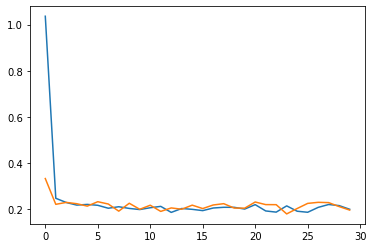

In [14]:
plt.plot(train_losses)
plt.plot(val_losses)

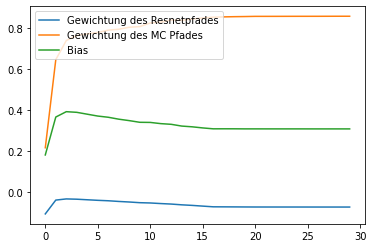

In [15]:
weightfc4 = [i.squeeze(0) for i in weight_fc4]
biasfc4 = torch.cat(bias_fc4).numpy()
plt.plot([i[0] for i in weightfc4], label = "Weighting of the resnet path")
plt.plot([i[1] for i in weightfc4], label = "Weighting of the MC path")
plt.plot(biasfc4, label = "Bias")
plt.legend()